# Porject Name

Team:
1. Renee Dhanaraj
2. Aditi Verma
3. Chris Park
4. Aryan Ahuja

In [1]:
# sklearn imports
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor

from sklearn.metrics import accuracy_score, mean_squared_error, f1_score

# data manipulation imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


## Importing dataset

In [2]:
original_dataset_df = pd.read_csv('dataset/dataset.csv')
original_dataset_df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## Data Cleaning

In [3]:
# creating a copy to clean to avoid contamination of original data
df = original_dataset_df.copy()

In [4]:
# information about the dataset, such as number of entries, column names, non-null counts, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [5]:
# getting the summary statistics of the dataset (of numerical features)
df.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [6]:
# checking for missing values in each column
df.isnull().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [7]:
# dropping all the rows with any missing/null values since there are very few
df = df.dropna()

# dropping unnecessary columns that won't help in prediction like id
df = df.drop(columns=["Unnamed: 0", "track_id"])

# IF WE PLAN TO NOT USE NLP FOR NATURAL LANGUAGE PROCESSING, UNCOMMENT AND DROP TEXT COLUMNS
# df = df.drop(columns=["artists", "album_name", "track_name", "track_genre"])

# making sure the "explicit" column is of type integer and not boolean
df["explicit"] = df["explicit"].astype(int)

In [8]:
# sanity checks for the important numeric columns
print("Popularity range:", df["popularity"].min(), "to", df["popularity"].max())
print("Duration range (ms):", df["duration_ms"].min(), "to", df["duration_ms"].max())
print("Tempo range:", df["tempo"].min(), "to", df["tempo"].max())
print("Loudness range:", df["loudness"].min(), "to", df["loudness"].max())

# duplicate check
duplicates_mask = df.duplicated(subset=["artists", "album_name", "track_name"])
print("Number of duplicate entries based on artists, album_name, track_name:", duplicates_mask.sum())


Popularity range: 0 to 100
Duration range (ms): 8586 to 5237295
Tempo range: 0.0 to 243.372
Loudness range: -49.531 to 4.532
Number of duplicate entries based on artists, album_name, track_name: 24620


In [9]:
# sanity checks for categorical columns
print("Explicit values:", df["explicit"].value_counts())
print("\nMode values:", df["mode"].value_counts())
print("\nTime signature values:", df["time_signature"].value_counts())
print("\nKey values:", df["key"].value_counts().sort_index())



Explicit values: explicit
0    104252
1      9747
Name: count, dtype: int64

Mode values: mode
1    72681
0    41318
Name: count, dtype: int64

Time signature values: time_signature
4    101842
3      9195
5      1826
1       973
0       163
Name: count, dtype: int64

Key values: key
0     13061
1     10772
2     11644
3      3570
4      9008
5      9368
6      7921
7     13244
8      7360
9     11313
10     7456
11     9282
Name: count, dtype: int64


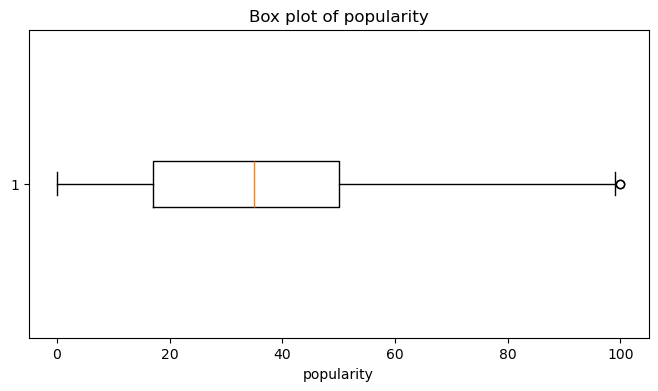

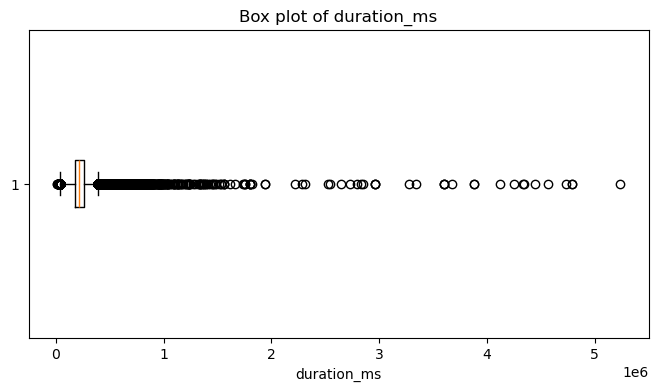

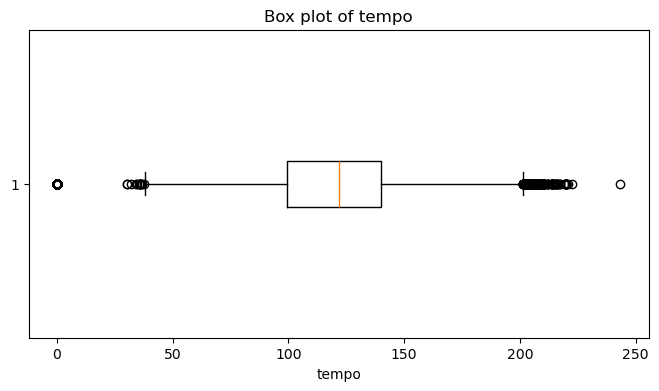

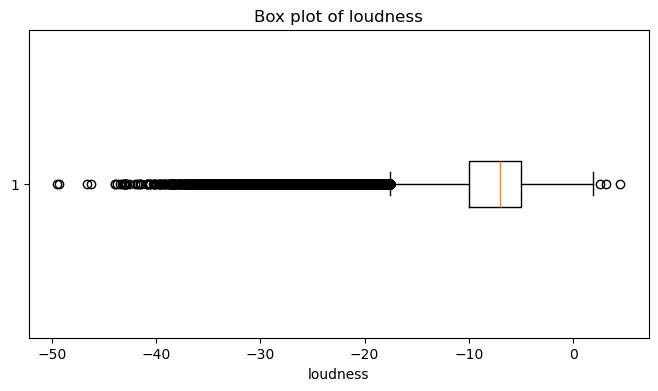

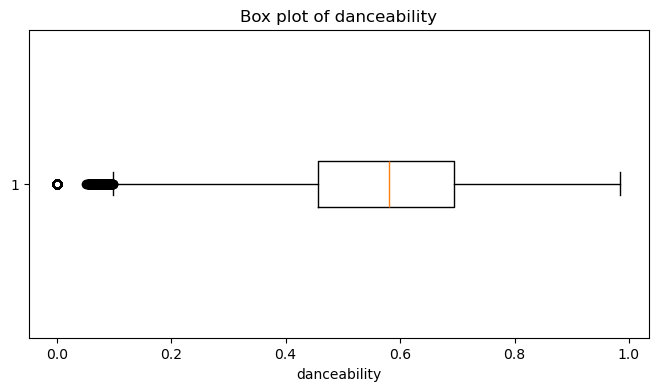

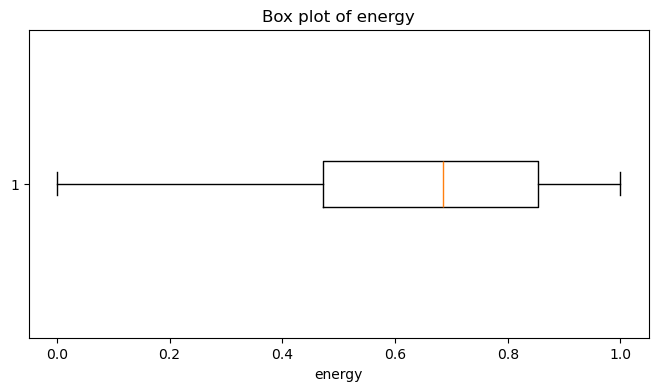

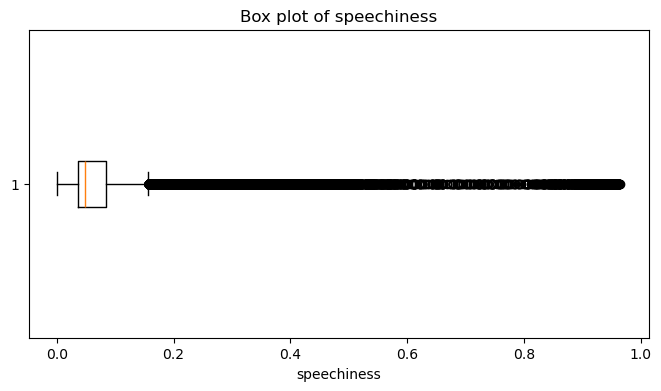

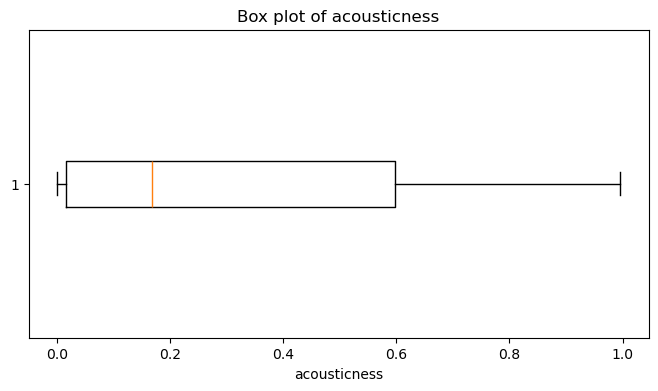

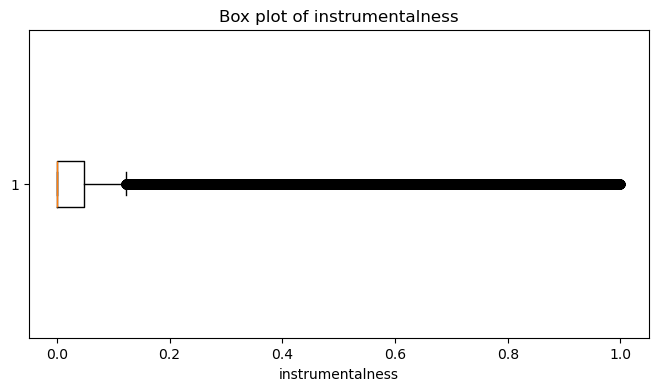

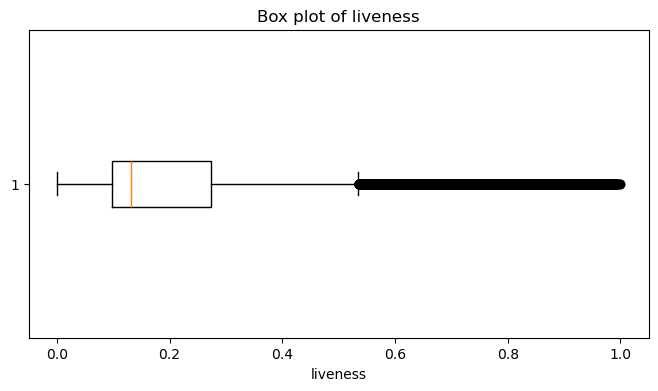

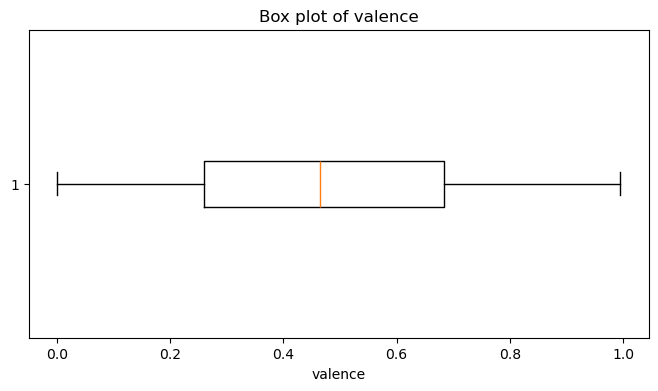

In [10]:
# checking for outliers in numerical columns using box plots
numerical_columns = ["popularity", "duration_ms", "tempo", "loudness", "danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Box plot of {col}')
    plt.xlabel(col)
    plt.show()

# We can see that some features are skewer, but if we train models like XGBoost, for ensemble methods, we need not do any transformations
# There are some outliers as well, but we still need to keep them since they are real songs and removing them would lead to loss of information
# Hence, we will not be doing any outlier removal or transformations for skewness at this point

# If required for training (linear models or nerual networks), we can always do log transformations or apply standardization/normalization later

In [11]:
df.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [12]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artists           113999 non-null  object 
 1   album_name        113999 non-null  object 
 2   track_name        113999 non-null  object 
 3   popularity        113999 non-null  int64  
 4   duration_ms       113999 non-null  int64  
 5   explicit          113999 non-null  int64  
 6   danceability      113999 non-null  float64
 7   energy            113999 non-null  float64
 8   key               113999 non-null  int64  
 9   loudness          113999 non-null  float64
 10  mode              113999 non-null  int64  
 11  speechiness       113999 non-null  float64
 12  acousticness      113999 non-null  float64
 13  instrumentalness  113999 non-null  float64
 14  liveness          113999 non-null  float64
 15  valence           113999 non-null  float64
 16  tempo             113999 

artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

## Exploratory Data Analysis (EDA)

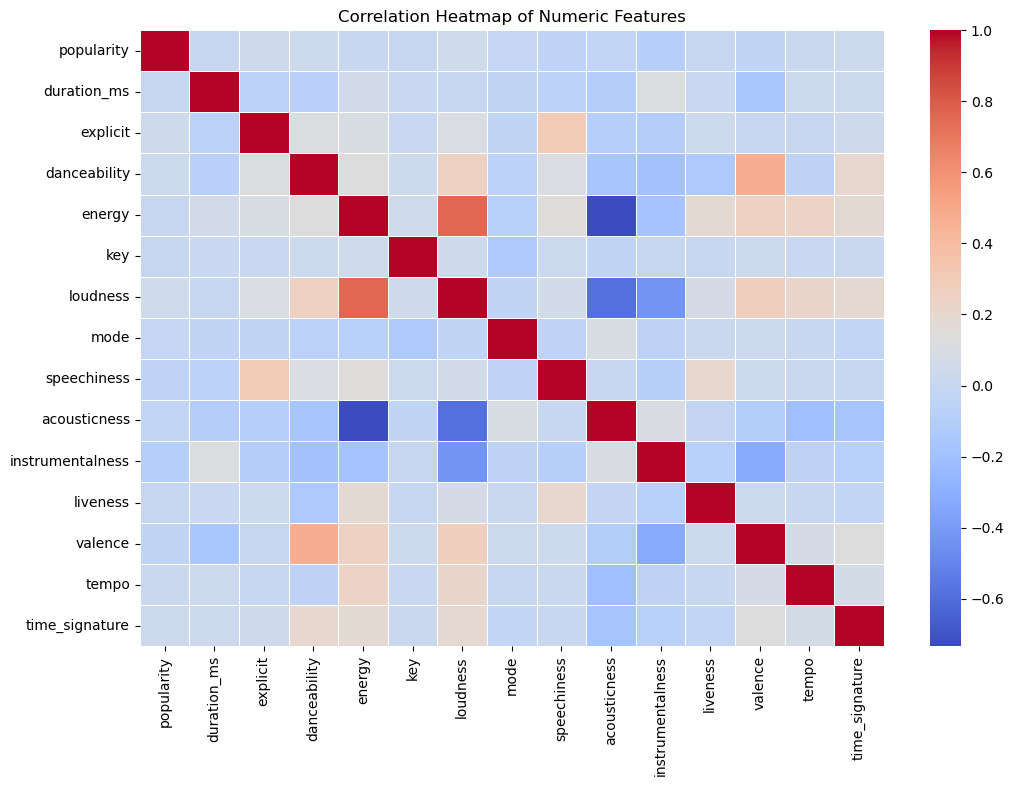

' OBSERVATIONS:\nGenerally a lot more negative corrolation than positive ones.\n\nSong Type\n    Negative corrolation: \n        energy + acousticness\n        loudness + acousticness\n        loudness + instrumentalness\n        valence + instrumentalness\n    \n    Positive corrolation:\n        loudness + energy\n        loudness + danceability\n        danceability + valence\n        energy + valence\n        speechiness + explicit\n\nPopularity\n    Negative corrolation:\n        popularity + instrumentalness\n        popularity + duration_ms\n\n    No positive corrolation :((\n'

In [13]:
#attempt visualizing a headmap 
#use only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

#compute correlation matrix
corr = numeric_df.corr()

#plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

""" OBSERVATIONS:
Generally a lot more negative corrolation than positive ones.

Song Type
    Negative corrolation: 
        energy + acousticness
        loudness + acousticness
        loudness + instrumentalness
        valence + instrumentalness
    
    Positive corrolation:
        loudness + energy
        loudness + danceability
        danceability + valence
        energy + valence
        speechiness + explicit

Popularity
    Negative corrolation:
        popularity + instrumentalness
        popularity + duration_ms

    No positive corrolation :((
"""

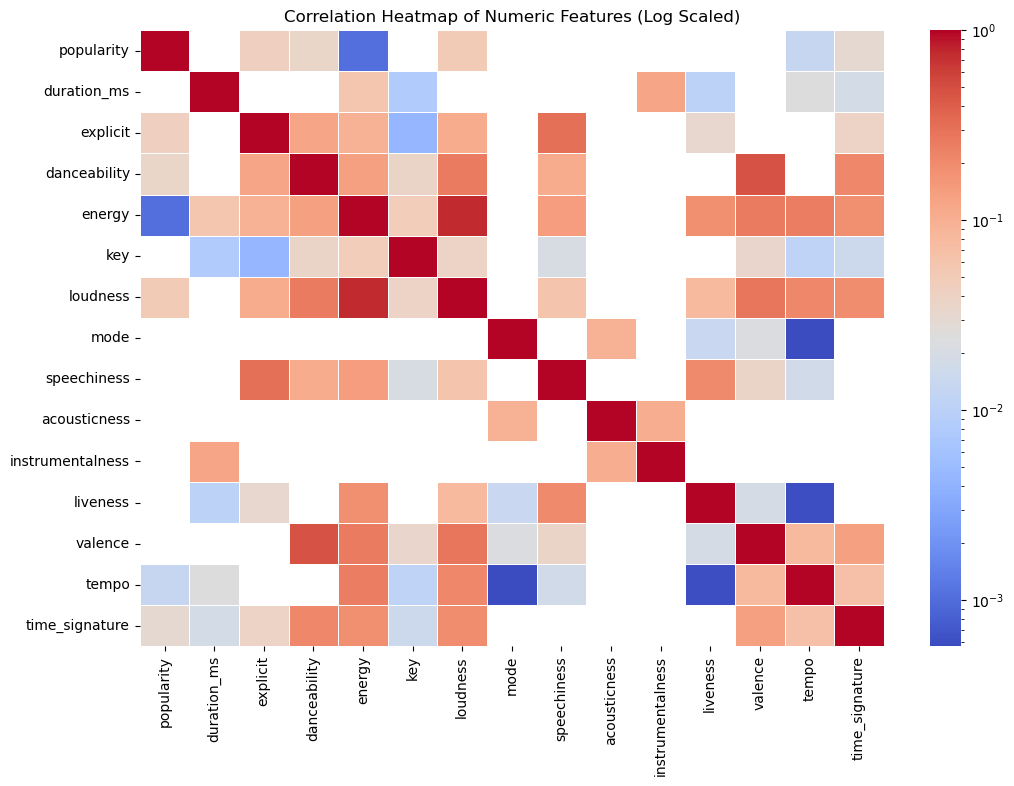

' OBSERVATIONS:\nGenerally a lot more positive corrolations\n\nPopularity\n    Negative corrolation:\n        energy\n        tempo\n\n    Positive corrolation:\n        explicit\n        danceability\n        loudness\n        time_signature\n        \n'

In [14]:
# Try normalizing using log_scale to address highly skewed datasets
plt.figure(figsize=(12, 8))
sns.heatmap(corr, norm=mcolors.LogNorm(), cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features (Log Scaled)")
plt.show()

""" OBSERVATIONS:
Generally a lot more positive corrolations

Popularity
    Negative corrolation:
        energy
        tempo

    Positive corrolation:
        explicit
        danceability
        loudness
        time_signature
        
"""
# dig deeper into the significant corrolations

##### More EDA that is related to popularity

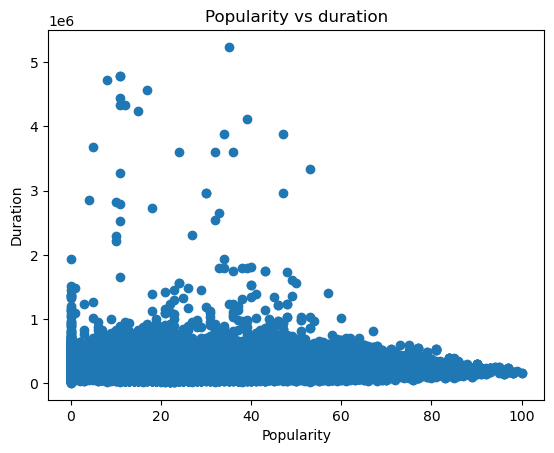

In [15]:
plt.scatter(df["popularity"], df["duration_ms"])
plt.xlabel("Popularity")
plt.ylabel("Duration")
plt.title("Popularity vs duration")
plt.show()
# df["duration"]

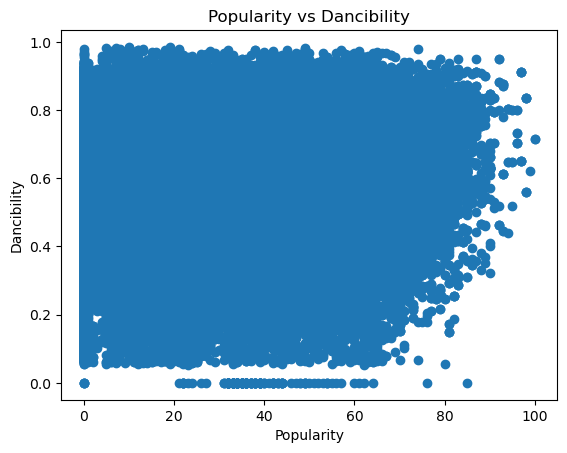

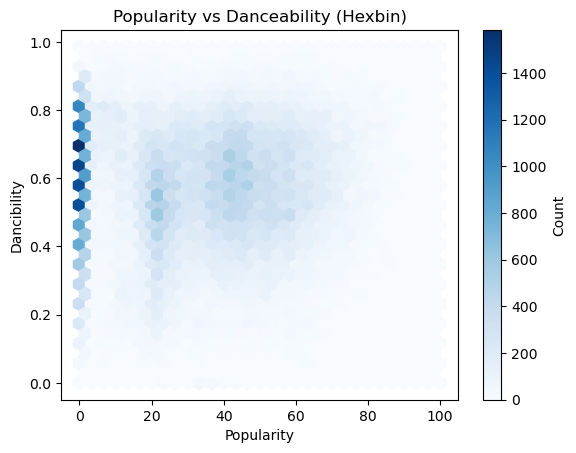

In [16]:
plt.scatter(df["popularity"], df["danceability"])
plt.xlabel("Popularity")
plt.ylabel("Dancibility")
plt.title("Popularity vs Dancibility")
plt.show()

plt.hexbin(df["popularity"], df["danceability"], gridsize=30, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel("Popularity")
plt.ylabel("Dancibility")
plt.title("Popularity vs Danceability (Hexbin)")
plt.show()

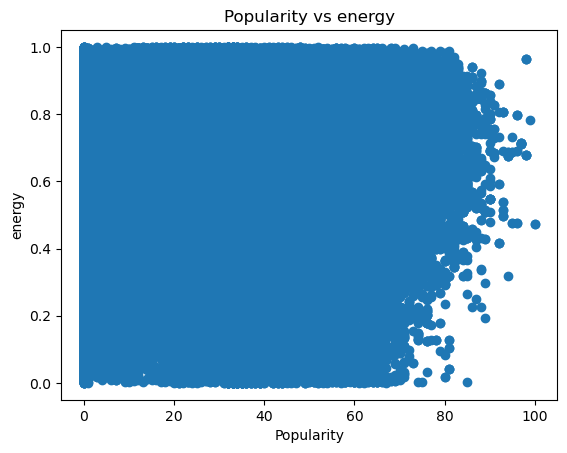

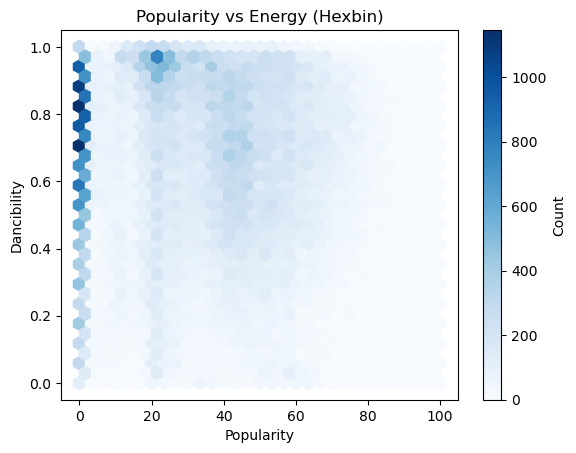

In [17]:
plt.scatter(df["popularity"], df["energy"])
plt.xlabel("Popularity")
plt.ylabel("energy")
plt.title("Popularity vs energy")
plt.show()

plt.hexbin(df["popularity"], df["energy"], gridsize=30, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel("Popularity")
plt.ylabel("Dancibility")
plt.title("Popularity vs Energy (Hexbin)")
plt.show()

Text(0.5, 1.0, 'Acustic distribution for songs with >50 popularity')

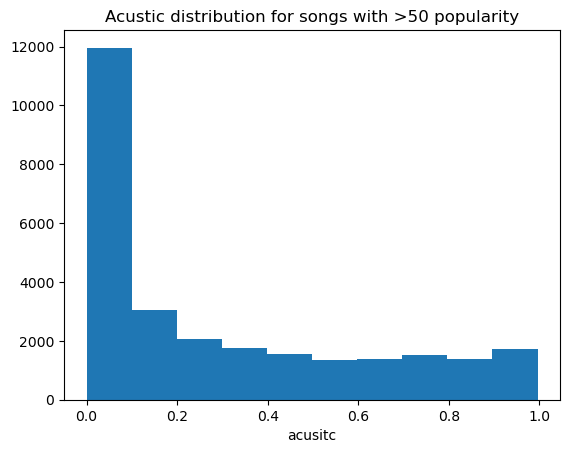

In [18]:
popular_songs = df[df.popularity > 50]
plt.hist(popular_songs["acousticness"])
plt.xlabel("acusitc")
plt.title("Acustic distribution for songs with >50 popularity")

Text(0.5, 1.0, 'danceability distribution for songs with > 0.7 dancability')

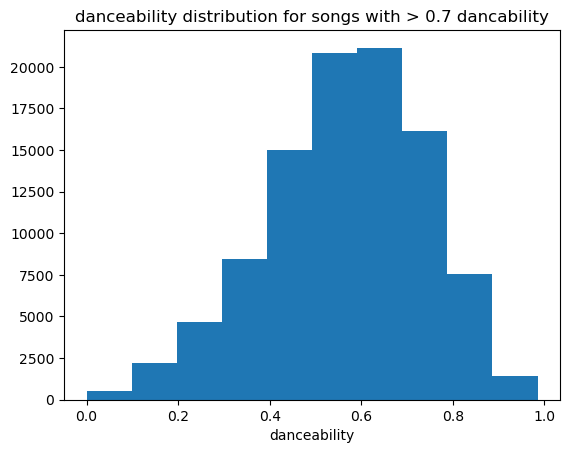

In [19]:
popular_songs = df[df.popularity > 0.7]
plt.hist(popular_songs["danceability"])
plt.xlabel("danceability")
plt.title("danceability distribution for songs with > 0.7 dancability")

/tmp/ipykernel_1331/4226924672.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values="popularity", index="danceability_q", columns="energy_q", aggfunc="mean")


<Axes: xlabel='energy_q', ylabel='danceability_q'>

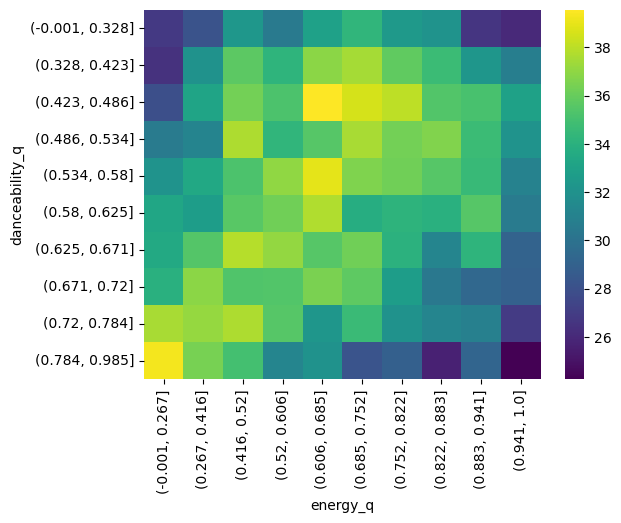

In [20]:
df["energy_q"] = pd.qcut(df["energy"], 10)
df["danceability_q"] = pd.qcut(df["danceability"], 10)
pivot = df.pivot_table(values="popularity", index="danceability_q", columns="energy_q", aggfunc="mean")
sns.heatmap(pivot, cmap="viridis")

In [21]:
#Average popularity per artist
artist_pop = df.groupby("artists")["popularity"].mean()


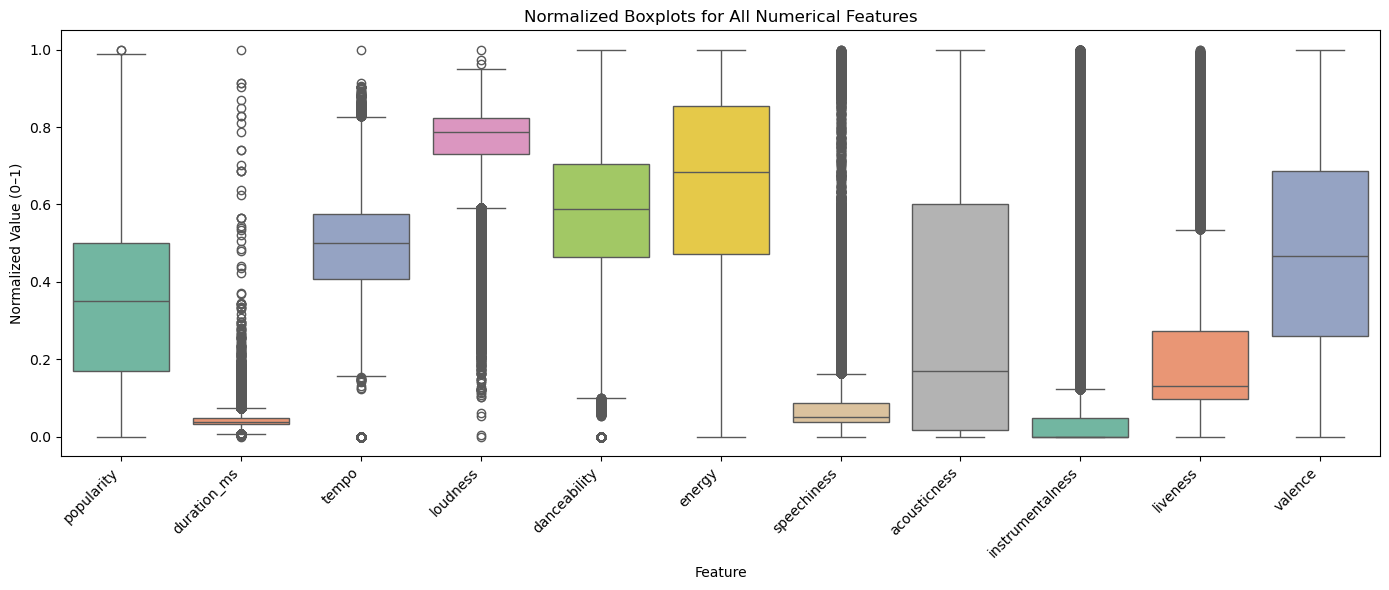

In [83]:
#normalize numerical columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[numerical_columns] = scaler.fit_transform(df[numerical_columns])

plt.figure(figsize=(14, 6))

df_melted = df_norm[numerical_columns].melt(var_name="Feature", value_name="Normalized")
sns.boxplot(
    data=df_melted,
    x="Feature",
    y="Normalized",
    hue="Feature",       
    palette="Set2",
    dodge=False         
)
plt.xticks(rotation=45, ha="right")
plt.title("Normalized Boxplots for All Numerical Features")
plt.ylabel("Normalized Value (0–1)")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

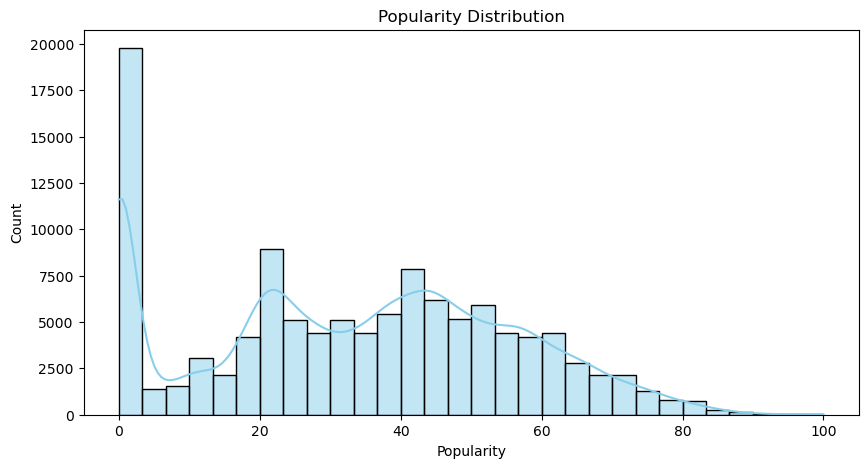

In [90]:
plt.figure(figsize=(10, 5))
sns.histplot(df['popularity'], bins=30, kde=True, color='skyblue')
plt.title('Popularity Distribution')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()

## Feature Engineering & Model Training

In [94]:
"""
    feature engineering for popularity
"""
df.loc[df['popularity'] < 40, 'popularity'] = 0   # Low
df.loc[(df['popularity'] >= 40) & (df['popularity'] < 70), 'popularity'] = 1  # Medium
df.loc[df['popularity'] >= 70, 'popularity'] = 2  # High

df['popularity'].value_counts()
df.head()


,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,energy_q,danceability_q,popularity_cat
0,Gen Hoshino,Comedy,Comedy,0,230666,0,0.676,0.4610,1,-6.746,...,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,"(0.416, 0.52]","(0.671, 0.72]",2
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,0,149610,0,0.420,0.1660,1,-17.235,...,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,"(-0.001, 0.267]","(0.328, 0.423]",2
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,0,210826,0,0.438,0.3590,0,-9.734,...,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,"(0.267, 0.416]","(0.423, 0.486]",2
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,0,201933,0,0.266,0.0596,0,-18.515,...,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,"(-0.001, 0.267]","(-0.001, 0.328]",2
4,Chord Overstreet,Hold On,Hold On,0,198853,0,0.618,0.4430,2,-9.681,...,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,"(0.416, 0.52]","(0.58, 0.625]",2


In [82]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def feature(df, col):
    X = df[col].copy()
    y = df["popularity"].astype(float)
    return X, y

def precision_at_k(predictions, y_true, ks=[1, 100, 1000, 10000]):
    precs = []
    for K in ks:
        top_pred = predictions[:min(K, len(predictions))]
        # true positives: ground truth values at top predicted indices
        true_positives = np.sum(y_true[top_pred] == 1)
        precs.append(true_positives / len(top_pred))
    return precs

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def evaluate(model, X, y, name="set"):
    y_pred = model.predict(X)
    print(f"\n=== {name.upper()} ===")
    print("R²:", r2_score(y, y_pred))
    print("MAE:", mean_absolute_error(y, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
    print("MSE:", mse(y, y_pred))

In [79]:
import random
random.seed(0)       
df_shuffled = df_norm.sample(frac=1, random_state=0).reset_index(drop=True)

N = len(df_norm)

train_end = int(0.5 * N)
valid_end = int(0.75 * N)   # 50% + 25%

dataTrain = df_norm[:train_end]
dataValid = df_norm[train_end:valid_end]
dataTest  = df_norm[valid_end:]

dfTrain = pd.DataFrame(dataTrain)
dfValid = pd.DataFrame(dataValid)
dfTest  = pd.DataFrame(dataTest)

"""FROM LOG-SCALED HEATMAP
    explicit          binary (0-1)
    danceability      float64
    loudness          float64
    time_signature    int64 (0-4)
    energy            float64
    tempo             float64

    key               int64 (0-11) 
"""

heatmap_feat = [
    "explicit",
    "danceability",
    "loudness",
    "tempo",
    "energy",
    "time_signature"
]

all_feat = [
    "explicit",
    "danceability",
    "energy",
    "loudness",
    "tempo",
    "acousticness",
    "speechiness",
    "instrumentalness",
    "liveness",
    "valence",
    "duration_ms",
    "key",
    "mode",
    "time_signature"
]

X_train, y_train = feature(dfTrain, heatmap_feat) #50%
X_valid, y_valid = feature(dfValid, heatmap_feat) #25%
X_test,  y_test  = feature(dfTest, heatmap_feat)  #25%

In [80]:
""" LINEAR REGRESSION
"""

from sklearn.linear_model import LinearRegression

# fit linear regression
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)

#evaluate
# Validation performance
evaluate(linearModel, X_valid, y_valid, "validation")

# Test performance
evaluate(linearModel, X_test, y_test, "test")


=== VALIDATION ===
R²: -0.011870816066855028
MAE: 0.19940692247141245
RMSE: 0.23403450175372625
MSE: 0.05477214801111489

=== TEST ===
R²: -0.06357341025456731
MAE: 0.18275042941854033
RMSE: 0.2238820710899357
MSE: 0.050123181755519025


In [81]:
""" RIDGE REGRESSION
    Linear regression is performing badly, (negative R2 score)
    Try accounting for corrolation in data

    Bad features
"""

from sklearn.linear_model import Ridge

# Fit Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Predictions
y_pred_valid = ridge.predict(X_valid)
y_pred_test  = ridge.predict(X_test)

# Evaluate on validation
evaluate(ridge, X_valid, y_valid, "Ridge Regression - Validation")

# Evaluate on test
evaluate(ridge, X_test, y_test, "Ridge Regression - Test")



=== RIDGE REGRESSION - VALIDATION ===
R²: -0.011689010305225622
MAE: 0.1994012042967652
RMSE: 0.2340134759806965
MSE: 0.05476230694056801

=== RIDGE REGRESSION - TEST ===
R²: -0.06294305666091549
MAE: 0.18270496068245068
RMSE: 0.22381571658012642
MSE: 0.05009347498827548


## Model Evaluation